# Slope Analysis

This project use the change of fluorecent intensity slope to identify responders from calcium imaging experiment.

## Analysis Steps

The `getBaselineAndMaxStimulationSlopeFromCSV` function smoothes the raw data by the moving window decided by `filterSize`, and analyzes the smoothed Ca intensity in an CSV and returns baseline slope and drug slope.

The _slope of baseline_ is calculated as the linear regression slope during the 3 minutes period before stimulation onset.

In addition, the smoothed data are separated into segments which n = regressionSize data points are included. The linear regression slope is then calculated for each segment. 

The _peak slope of stimulation_ is the most negative slope during the chosen stimulation period.

## Set-Up the Environment

In [176]:
%load_ext autoreload
import sys
sys.path.append("../src")
import os
import glob
import slopeTools
import plotTools
import statsTools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from scipy.optimize import curve_fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pandas DataFrame as a Database

This script creates a single dataframe containing AFU data for every structure in all experiments. 

Columns define group, drug, distance, structure, etc.

This large dataframe can be queried as needed, or exported as a CSV.

In [177]:
database = pd.DataFrame(columns = ['Group', 'Distance', 'MCN','Sniffer','AFU'])

def addGroup(folderPath, groupName):    
    filePaths = glob.glob(folderPath+"/*.xls")
    filePaths = [x for x in filePaths if x.endswith("um.xls")]
    for filePath in filePaths:
        fileName = os.path.basename(filePath)
        #distance = int(fileName.replace("um.xls", ""))
        addExperiment(filePath, groupName)
        
def addExperiment(filePath, groupName):    
    global database   #global reads a variable outside the function
    df = pd.read_csv(filePath, delimiter="\t")
    roiNames = df.columns[1:] #return to the column labels 
    for roiName in roiNames:
        mcn, distance, sniffer = roiName.split(".")
        distance = int(distance.replace("um", ""))
        afu = df[roiName].values
        row = {'Group': groupName, 'Distance': distance, 'MCN': mcn, 'Sniffer':sniffer, 'AFU':afu}
        database = database.append(row,ignore_index = True)
        
addGroup(R"X:\Data\OT-Cre\OT-GCaMP-nonspecific\04-03-19 evoke OT\04-30-2020 Cs-GLU analyze", "CsGlu")
addGroup(R"X:\Data\OT-Cre\OT-GCaMP-nonspecific\04-03-19 evoke OT\04-30-2020 K-GLU analyze", "KGlu")
addGroup(R"X:\Data\OT-Cre\OT-GCaMP-nonspecific\04-03-19 evoke OT\04-30-2020 L368 - Cs analyze", "L368")

database

,Group,Distance,MCN,Sniffer,AFU
0,CsGlu,25,19514000,C1,"[1286.65983, 1266.2571699999999, 1189.49916999..."
1,CsGlu,25,19514000,C2,"[2948.64467, 2962.93833, 3239.71167, 3417.8625..."
2,CsGlu,25,19514000,C3,"[5736.4195, 5736.50717, 5026.41233, 4580.00867..."
3,CsGlu,25,19514000,C4,"[2283.93833, 2211.74517, 2253.62167, 2301.0938..."
4,CsGlu,25,19514000,C5,"[2045.98417, 1792.38467, 2021.4029999999998, 1..."
...,...,...,...,...,...
441,L368,125,20217028,C15,"[1024.454, 1141.7939999999999, 1079.1860000000..."
442,L368,125,20217028,C16,"[1149.15, 1137.655, 1136.93, 1116.005, 1118.42..."
443,L368,125,20217028,C17,"[3113.2129999999997, 2974.022, 3031.2940000000..."
444,L368,125,20217028,C18,"[1648.366, 1611.486, 1646.211, 1597.274, 1576...."


# Convert raw AFU into dF/F (%)

In [178]:
baselineStartIndex = 20
treatmentStartIndex = 30
experimentPeriod = 5/60 #min
dFoFs = []
analyzed = database.copy()

analyzed["BaselineAFUMeans"] = [np.mean(x[baselineStartIndex:treatmentStartIndex]) for x in analyzed["AFU"].values]
for i in range(len(analyzed["AFU"])):
    dFoF = (analyzed["AFU"][i]-analyzed["BaselineAFUMeans"][i])*100/analyzed["BaselineAFUMeans"][i]
    dFoFs.append(dFoF)
    
analyzed["Raw dF/F (%)"] = dFoFs

analyzed = analyzed.drop(columns=["AFU", "BaselineAFUMeans"], axis=1)


analyzed

,Group,Distance,MCN,Sniffer,Raw dF/F (%)
0,CsGlu,25,19514000,C1,"[26.876577163943114, 24.864685904510754, 17.29..."
1,CsGlu,25,19514000,C2,"[-1.6574346372227533, -1.1807155509507214, 8.0..."
2,CsGlu,25,19514000,C3,"[28.56409879575307, 28.56606364761605, 12.6514..."
3,CsGlu,25,19514000,C4,"[27.972329497133295, 23.927243542925748, 26.27..."
4,CsGlu,25,19514000,C5,"[23.747368607671493, 8.408896655945105, 22.260..."
...,...,...,...,...,...
441,L368,125,20217028,C15,"[-0.5552749665760618, 10.83503053803611, 4.757..."
442,L368,125,20217028,C16,"[11.070408867461687, 9.959366488371503, 9.8892..."
443,L368,125,20217028,C17,"[37.94349143568214, 31.77607130849393, 34.3137..."
444,L368,125,20217028,C18,"[12.440712290178862, 9.925000688955723, 12.293..."


# Smooth raw data by filtersize

In [179]:
filterSize = 5
regressionSize = 10

length = [len(x) for x in analyzed["Raw dF/F (%)"].values]
maxLength = max(length)
time = np.arange(maxLength)*experimentPeriod 
smoothTimes = statsTools.smoothY(time, filterSize)
analyzed["dF/F (%)"] = [statsTools.smoothY(x, filterSize) for x in analyzed["Raw dF/F (%)"].values]
analyzed


,Group,Distance,MCN,Sniffer,Raw dF/F (%),dF/F (%)
0,CsGlu,25,19514000,C1,"[26.876577163943114, 24.864685904510754, 17.29...","[21.84072307926667, 19.003907158001294, 16.241..."
1,CsGlu,25,19514000,C2,"[-1.6574346372227533, -1.1807155509507214, 8.0...","[7.763973194601914, 9.775688043374481, 11.1001..."
2,CsGlu,25,19514000,C3,"[28.56409879575307, 28.56606364761605, 12.6514...","[9.291335093843292, 10.769249062288777, 13.264..."
3,CsGlu,25,19514000,C4,"[27.972329497133295, 23.927243542925748, 26.27...","[28.11335145335973, 28.311119053030833, 28.082..."
4,CsGlu,25,19514000,C5,"[23.747368607671493, 8.408896655945105, 22.260...","[19.80381459331928, 18.16510188118031, 18.1830..."
...,...,...,...,...,...,...
441,L368,125,20217028,C15,"[-0.5552749665760618, 10.83503053803611, 4.757...","[10.466257991487444, 13.406909232091417, 14.97..."
442,L368,125,20217028,C16,"[11.070408867461687, 9.959366488371503, 9.8892...","[9.279000026418869, 8.943125970974036, 8.57640..."
443,L368,125,20217028,C17,"[37.94349143568214, 31.77607130849393, 34.3137...","[27.990417371697415, 25.14774112198889, 22.706..."
444,L368,125,20217028,C18,"[12.440712290178862, 9.925000688955723, 12.293...","[10.585477304434109, 9.142399281266824, 8.3357..."


# Delete sniffers that show severe exponential decay 

In [180]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

def calcRsquared(actual, expected):
    """Calculate rSquared discretely so we don't need sklearn."""
    squaredDiffs = np.power(actual - expected, 2)
    squaredDiffsFromMean = np.power(actual - np.mean(actual), 2)
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    return rSquared

def exponentialDecayFit(xs, ys):

    xs = np.array(xs)
    ys = np.array(ys)

    #plt.plot(xs, ys, '.')
    
    params, cv = curve_fit(monoExp, xs, ys,bounds=(-40, [2000, 30, 50]))
    m, t, b = params
    sampleRate = 20_000 # Hz
    tauSec = (1 / t) / sampleRate

    expCurveFitted = monoExp(xs, *params)
    expRsquared = calcRsquared(ys, expCurveFitted)
    #plt.plot(xs, monoExp(xs, m, t, b), '--', label="fitted")
    #print(expRsquared)
    return expRsquared
indexes =[]
for ysIndex in range(len(analyzed["dF/F (%)"])):
    ys = analyzed["dF/F (%)"].values[ysIndex]
    xs = smoothTimes[:len(ys)]
    rSquare = exponentialDecayFit(xs, ys)

    if rSquare > 0.95:
        indexes.append(ysIndex)
        analyzedCleaned = analyzed.drop(index=indexes, axis=1)


analyzedCleaned


,Group,Distance,MCN,Sniffer,Raw dF/F (%),dF/F (%)
0,CsGlu,25,19514000,C1,"[26.876577163943114, 24.864685904510754, 17.29...","[21.84072307926667, 19.003907158001294, 16.241..."
1,CsGlu,25,19514000,C2,"[-1.6574346372227533, -1.1807155509507214, 8.0...","[7.763973194601914, 9.775688043374481, 11.1001..."
2,CsGlu,25,19514000,C3,"[28.56409879575307, 28.56606364761605, 12.6514...","[9.291335093843292, 10.769249062288777, 13.264..."
3,CsGlu,25,19514000,C4,"[27.972329497133295, 23.927243542925748, 26.27...","[28.11335145335973, 28.311119053030833, 28.082..."
4,CsGlu,25,19514000,C5,"[23.747368607671493, 8.408896655945105, 22.260...","[19.80381459331928, 18.16510188118031, 18.1830..."
...,...,...,...,...,...,...
439,L368,125,20217028,C13,"[5.3879113704520245, 6.751616748552907, 13.206...","[10.71871125433559, 12.146685792190334, 11.687..."
440,L368,125,20217028,C14,"[9.719523274884832, 11.879961915722674, 11.922...","[10.879969781874658, 10.795907846214332, 10.42..."
441,L368,125,20217028,C15,"[-0.5552749665760618, 10.83503053803611, 4.757...","[10.466257991487444, 13.406909232091417, 14.97..."
442,L368,125,20217028,C16,"[11.070408867461687, 9.959366488371503, 9.8892...","[9.279000026418869, 8.943125970974036, 8.57640..."


# Calculate the slope difference for each sniffer cell

In [181]:
baselineStartIndex = 20 + 2 # index is right shifted for 2.5 indexes after smoothing
treatmentStartIndex = 30 + 2 

def slopeDifferenceWithDataFrame(dataframe, dataColume,baselineStartIndex, treatmentStartIndex, treatmentDuration = 2.5):
    """
    This function uses the datacolume from a dataframe, calculates the baseline slope and the maximal treatment slope, 
    and generates a new column called "slope difference (%)" to show the change of slopes.
    """
    baselineSlopes =[]
    stimulationSlopes =[]
    baselineDFoFs = [x[baselineStartIndex:treatmentStartIndex] for x in dataframe[dataColume].values]        
    baselineTime = time[baselineStartIndex:treatmentStartIndex]

    for baselineDFoF in baselineDFoFs:
        baselineSlope, baselineIntercept, r, p, stdErr = scipy.stats.linregress(baselineTime, baselineDFoF)
        baselineSlopes.append(baselineSlope)

    smoothedIntensities = [x for x in dataframe[dataColume].values]
    for smoothedIntensity in smoothedIntensities:
        segments = statsTools.getMovingWindowSegments(smoothedIntensity, regressionSize) 
        segSlopes = slopeTools.getAllSegmentSlopes(segments, experimentPeriod)   
        segTimesOffset = (regressionSize * experimentPeriod)
        segTimes = statsTools.smoothY(smoothTimes, filterSize)
        treatmentStartTime = smoothTimes[treatmentStartIndex]
        treatmentEndTime = treatmentStartTime + treatmentDuration
        treatmentSlopeMax = statsTools.rangeMax(segSlopes, segTimes, treatmentStartTime, treatmentEndTime)
        treatmentSlopeMaxIndex = segSlopes.index(treatmentSlopeMax)
        treatmentSlopeMaxTime = segTimes[treatmentSlopeMaxIndex]
        stimulationSlopes.append(treatmentSlopeMax)

    dataframe["slopeDifference (%)"] = [stimulationSlopes[i] - baselineSlopes[i] for i in range(len(baselineSlopes))]

slopeDifferenceWithDataFrame(analyzedCleaned, 'dF/F (%)', baselineStartIndex, treatmentStartIndex)
analyzedCleaned

,Group,Distance,MCN,Sniffer,Raw dF/F (%),dF/F (%),slopeDifference (%)
0,CsGlu,25,19514000,C1,"[26.876577163943114, 24.864685904510754, 17.29...","[21.84072307926667, 19.003907158001294, 16.241...",1.583719
1,CsGlu,25,19514000,C2,"[-1.6574346372227533, -1.1807155509507214, 8.0...","[7.763973194601914, 9.775688043374481, 11.1001...",3.008474
2,CsGlu,25,19514000,C3,"[28.56409879575307, 28.56606364761605, 12.6514...","[9.291335093843292, 10.769249062288777, 13.264...",6.938414
3,CsGlu,25,19514000,C4,"[27.972329497133295, 23.927243542925748, 26.27...","[28.11335145335973, 28.311119053030833, 28.082...",1.363140
4,CsGlu,25,19514000,C5,"[23.747368607671493, 8.408896655945105, 22.260...","[19.80381459331928, 18.16510188118031, 18.1830...",6.564383
...,...,...,...,...,...,...,...
439,L368,125,20217028,C13,"[5.3879113704520245, 6.751616748552907, 13.206...","[10.71871125433559, 12.146685792190334, 11.687...",10.324494
440,L368,125,20217028,C14,"[9.719523274884832, 11.879961915722674, 11.922...","[10.879969781874658, 10.795907846214332, 10.42...",8.202691
441,L368,125,20217028,C15,"[-0.5552749665760618, 10.83503053803611, 4.757...","[10.466257991487444, 13.406909232091417, 14.97...",42.662835
442,L368,125,20217028,C16,"[11.070408867461687, 9.959366488371503, 9.8892...","[9.279000026418869, 8.943125970974036, 8.57640...",7.960732


# Plot response rate by groups

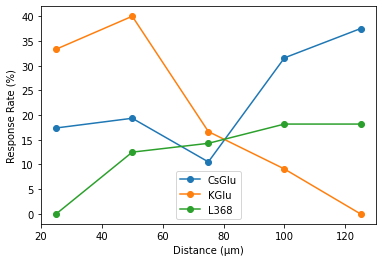

In [188]:
def identifyResponders(df, groupName, distance, slopeDifferenceThreshold):
    """
    Given a dataframe, group, and distance, return just the cells that change
    more than the given threshold.
    """
    matching = df.loc[analyzed['Group'] == group]
    matching = matching.loc[analyzedCleaned['Distance'] == distance]
    totalCellCount = len(matching)
    matching = matching.loc[analyzedCleaned['slopeDifference (%)'] > slopeDifferenceThreshold]
    responderCount = len(matching)
    return matching, totalCellCount, responderCount
    

groups = ["CsGlu", "KGlu", "L368"]
distances = [25, 50, 75, 100, 125]
threshold = 17


responseFrame = pd.DataFrame(index=[distances], columns=[groups])
for group in groups:
    responseByDistance = []
    for distance in distances:
        matching, totalCellCount, responderCount = identifyResponders(analyzedCleaned, group, distance, threshold)
        #sniffers = sorted(list(set(matching['MCN'])))
        responseRate = responderCount*100/totalCellCount
        responseByDistance.append(responseRate)
    
    plt.plot(distances, responseByDistance, 'o-', label=group)

plt.legend()
plt.ylabel("Response Rate (%)")
plt.xlabel("Distance (µm)")
plt.show()


# Plot the calcium signal and slops over time of individual cell

## Define CSV Files and Filter Settings

The user can list the ABF files they want to analyze

In [ ]:
def getBaselineAndMaxStimulationSlopeFromCSV(rawTimes,rawIntensity, filterSize = 15, regressionSize = 15):
    """
    This method analyzes fluorecent intensuty in a CSV and returns baseline slope and stimulation slope.
    
    Arguments:
        filterSize: number of points (sweeps) for the moving window average
        regressionSize: number of points (sweeps) to use to calculate regression slopes during the stimulation range
        
    Returns:
        baseline regression slope (over full range)
        peak stimulus regression slope (regression over defined size)
    """
    experimentPeriod = 5/60 #min
    ######
    ##########
    #########

    # determine the time range of stimulus and baseline
    stimulationTimeStart = rawTimes[30]
    stimulationSearchWidth = 30 # index
    stimulationTimeEnd = rawTimes[30 + stimulationSearchWidth]
    baselineTimeStart = stimulationTimeStart-1.5
    baselineTimeEnd = stimulationTimeStart
    
    plt.axvspan(stimulationTimeStart, stimulationTimeEnd, color='r', alpha=.1)#############

    # determine baseline region based on stimulation time
    baselineTimeStart = stimulationTimeStart-1.5
    baselineTimeEnd = stimulationTimeStart
    
    baselineMean = np.mean(rawIntensity[20:30])
    rawDFoF = (rawIntensity - baselineMean)*100/baselineMean
    plt.plot(rawTimes, rawDFoF, '.', alpha=.5)
    smoothIntensity, smoothTimes = statsTools.smoothY(rawDFoF, rawTimes, filterSize)
    plt.plot(smoothTimes, smoothIntensity, '-')
    
    
    baselineIndexStart, baselineIndexEnd = statsTools.rangeIndex(smoothTimes, baselineTimeStart, baselineTimeEnd)
    baselineIntensity = smoothIntensity[baselineIndexStart:baselineIndexEnd]
    plt.axvspan(baselineTimeStart, baselineTimeEnd, color='b', alpha=.1)

    # isolate smoothed baseline intensity
    baselineIntensity = smoothIntensity[baselineIndexStart:baselineIndexEnd]
    baselineTimes = smoothTimes[baselineIndexStart:baselineIndexEnd]
    baselineSlope, baselineIntercept, r, p, stdErr = scipy.stats.linregress(baselineTimes, baselineIntensity)
    # calculate linear regression of baseline region
    baselineRegressionXs = np.linspace(baselineTimeStart, baselineTimeEnd)
    baselineRegressionYs = baselineRegressionXs * baselineSlope + baselineIntercept
    plt.plot(baselineRegressionXs, baselineRegressionYs, color='b', ls='--')
    print(f"Baseline slope: {baselineSlope} AFU/min")

    # perform a moving window linear regression on the smoothed Intensity
    segments = statsTools.getMovingWindowSegments(smoothIntensity, regressionSize)
    segSlopes = slopeTools.getAllSegmentSlopes(segments, experimentPeriod)   
    segTimesOffset = (regressionSize * experimentPeriod)
    segTimes = np.arange(len(segSlopes)) * experimentPeriod + segTimesOffset    
    plt.subplot(212, sharex = ax1)
    plt.plot(segTimes, segSlopes, '.')

    # search the stimulation range for the most positive slope
    plt.axvspan(stimulationTimeStart, stimulationTimeEnd, color='r', alpha=.1)
    stimulationSlopeMax = statsTools.rangeMax(segSlopes, segTimes, stimulationTimeStart, stimulationTimeEnd)
    stimulationSlopeMaxIndex = segSlopes.index(stimulationSlopeMax)
    stimulationSlopeMaxTime = segTimes[stimulationSlopeMaxIndex]
    print(f"stimulation slope: {stimulationSlopeMax} AFU/min")
    plt.axvline(stimulationSlopeMaxTime, color='r', ls='--')
    plt.axhline(stimulationSlopeMax, color='r', ls='--')
    plt.axhline(baselineSlope, color='b', ls='--')

    plt.ylabel("Slope (AFU/min)")
    plt.xlabel("Time (minutes)")

    plt.show()
    
    return baselineSlope, stimulationSlopeMax

In [ ]:
csvFilePaths = [R"X:\Data\OT-Cre\OT-GCaMP-nonspecific\04-03-19 evoke OT\04-30-2020 L368 - Cs analyze\075um.xls",
                #R"X:\Data\OT-Cre\OT-GCaMP-nonspecific\04-03-19 evoke OT\04-30-2020 Cs-glu analyze\025um.xls"
               ]

The users can decide the parameters they want for data analysis. 

`filterSize` decides number of points (sweeps) for the moving window average. 

`regressionSize` decides the number of smoothed data points used to calculate linear regression slopes during the stimulation range.

In [ ]:
filterSize = 5
regressionSize = 10

## Analyze All CSVs

In [ ]:
baselineSlopes = []
stimulationSlopes = []
for csvFilePath in csvFilePaths:
    csvData = pd.read_csv(csvFilePath, delimiter="\t")
    roiNames = csvData.columns[1:]
    framePeriodSeconds = 5.0
    framesPerMinute = 60 / framePeriodSeconds
    times = csvData['Time'].values / framesPerMinute


    for roiName in roiNames:
        plt.figure(figsize=(8, 6))
        ax1 = plt.subplot(211)
        plt.title(roiName)
        plt.ylabel("dF/F (%)")
        rawIntensity = csvData[roiName].values
        baselineSlope, stimulationSlope = getBaselineAndMaxStimulationSlopeFromCSV(times, rawIntensity, filterSize, regressionSize)

        baselineSlopes.append(baselineSlope)
        stimulationSlopes.append(stimulationSlope)

## Compare Baseline vs. Stimulation Slopes

The users can plot the basleine slope and the peak stimulation slope of each cell, and report the p-value in the title by performing a paired t-test between baseline slopes and peak stimulation slopes.

In [ ]:
plotTools.plotPairs(baselineSlopes, stimulationSlopes, "slopes")

## Assess Responsiveness of All Cells

Generate a scatter plot showing the slope difference of each cell.

In [ ]:
slopeThreshold = 15
stimulationEffects = []
for i in range(len(roiNames)):
    stimulationEffects.append(stimulationSlopes[i] - baselineSlopes[i])

plt.figure (figsize=(12, 4))
plt.ylabel("Slope Difference (%/min)")
plt.plot(roiNames, stimulationEffects, 'o', color = "b")
plt.gca().set_xticklabels(roiNames, rotation=45, ha='right')
plt.axhline(slopeThreshold, color='r', ls='--')
plt.show()

## Define Cells as Responsive vs. Non-Responsive

The users can define the <b>slopeThreshold</b>. The difference between baseline slope and peak stimulation slope must be more negative than this value to be a responder
slopeThreshold

In [ ]:
stimulationEffects=statsTools.responderByDelta(roiNames, stimulationEffects, slopeThreshold)

In [107]:
demo1 = [5, 2, 3]
demo2 = [7, 3, 4]

demo1 = np.array(demo1)
demo2 = np.array(demo2)

print(type(demo1), type(demo2))
print(demo1 + demo2)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[12  5  7]
